In [16]:
import heapq
import itertools
import matplotlib.pyplot as plt
import random
import pickle
from math import atan2


In [17]:
def to_convex_contour(vertices_count,
                      x_limits,
                      y_limits):
    """
    PARAMETERS:
    -----------
    vertices_count: int
        Number of vertices in the polygon
    x_limits: (int, int)
        Lower and Higher X limits
    y_limits: (int, int)
        Lower and Higher Y limits
    
    RETURNS:
    --------
    list((x, y))
        N points such that successive points are connected by an edge.
    """
    xs = set()
    ys = set()
    
    while len(xs) != vertices_count:
        xs.add(random.randint(x_limits[0], x_limits[1]))
    
    while len(ys) != vertices_count:
        ys.add(random.randint(y_limits[0], y_limits[1]))

    xs = sorted(list(xs))
    ys = sorted(list(ys))
    min_x, *xs, max_x = xs
    min_y, *ys, max_y = ys
    vectors_xs = _to_vectors_coordinates(xs, min_x, max_x)
    vectors_ys = _to_vectors_coordinates(ys, min_y, max_y)
    random.shuffle(vectors_ys)

    def to_vector_angle(vector):
        x, y = vector
        return atan2(y, x)

    vectors = sorted(zip(vectors_xs, vectors_ys),
                     key=to_vector_angle)
    point_x = point_y = 0
    min_polygon_x = min_polygon_y = 0
    points = []
    for vector_x, vector_y in vectors:
        points.append((point_x, point_y))
        point_x += vector_x
        point_y += vector_y
        min_polygon_x = min(min_polygon_x, point_x)
        min_polygon_y = min(min_polygon_y, point_y)
    shift_x, shift_y = min_x - min_polygon_x, min_y - min_polygon_y
    return [(point_x + shift_x, point_y + shift_y)
            for point_x, point_y in points]


def _to_vectors_coordinates(coordinates, min_coordinate, max_coordinate):
    last_min = last_max = min_coordinate
    result = []
    for coordinate in coordinates:
        if _to_random_boolean():
            result.append(coordinate - last_min)
            last_min = coordinate
        else:
            result.append(last_max - coordinate)
            last_max = coordinate
    result.extend((max_coordinate - last_min,
                   last_max - max_coordinate))
    return result


def _to_random_boolean():
    return random.getrandbits(1)

In [18]:
plt.rcParams["figure.figsize"] = (10,10)

In [19]:
class Polygon(object):
    __slots__ = ['no_vertices', 'vertices', 'edges']

    def __init__(self, no_vertices, vertices):
        self.no_vertices = no_vertices
        self.vertices = vertices[:]
        self.create_edges()

    def create_edges(self):
        self.edges = []
        for i in range(0, len(self.vertices)-1):
            self.edges.append(Line(self.vertices[i], self.vertices[i+1]))
        self.edges.append(Line(self.vertices[-1], self.vertices[0]))

    def plot(self):
        vertices = self.vertices
        vertices.append(vertices[0])
        for i in range(len(vertices)-1):
            plt.plot([vertices[i][0], vertices[i+1][0]], [vertices[i][1], vertices[i+1][1]], 'b')


In [20]:
class Line(object):
    __slots__ = ['start', 'end']

    def __init__(self, start, end):
        self.start = start
        self.end = end

    def is_intersecting(self , other):
        start_point, end_point = other.start, other.end

        if self.end[0] != self.start[0]:
            m_self =  (self.end[1] - self.start[1]) / (self.end[0] - self.start[0])
            c_self = self.end[1] - (m_self * self.end[0])

            # eqn of line is m x - y + c = 0

            sign_start = (start_point[0] * m_self) - start_point[1] + c_self
            sign_end = (end_point[0] * m_self ) - end_point[1] + c_self
        else:
            # eqn is x - c = 0
            c_self = self.end[0]
            sign_start = start_point[0] - c_self
            sign_end = end_point[0] - c_self

        if sign_start == 0 and sign_end == 0:
            return False
        
        sign_start = sign_start > 0
        sign_end = sign_end > 0

        return not sign_start == sign_end
    

    def length(self):
        return ((self.start[0] - self.end[0])**2 + (self.start[1] - self.end[1])**2)**0.5


In [21]:
class State(object):
    __slots__ = ['point', 'distance_from_start', 'goal', 'parent']

    def __init__(self, point, distance_from_start, goal, parent):
        self.point = point
        self.distance_from_start = distance_from_start
        self.goal = goal
        self.parent = parent

    def generate_successors(self, obstacles):
        line = Line(self.point, self.goal)
        if check_intersection(line, obstacles) == False:
            return [State(self.goal, self.distance_from_start + line.length(), self.goal, self)]

        successors = []

        for x_add, y_add in itertools.product([-1, 0, 1], [-1, 0, 1]):
            if x_add == 0 and y_add == 0:
                continue
            new_point = tuple((self.point[0] + x_add, self.point[1] + y_add))
            if not valid_point(new_point, (0, 50), (0, 50)):
                continue
            line = Line(self.point, new_point)
            if check_intersection(line, obstacles) == False:
                successors.append(State(new_point, self.distance_from_start + line.length(), self.goal, self))
        
        return successors
        
    def heuristics(self):
        line = Line(self.point, self.goal)
        return self.distance_from_start + line.length()

    def goal_test(self):
        return self.point == self.goal

    def __lt__(self, other):
        return self.heuristics() < other.heuristics()
    
    def __gt__(self, other):
        return self.heuristics() > other.heuristics()

    def __str__(self):
        return str(self.point)

    def __eq__(self, other):
        return self.point == other.point
    
    def __hash__(self):
        s = str(self.point)
        return hash(s)

In [22]:
def generate_obstacles():
    """
    Generates random polygons in the search space having 3 to 8 vertices
    """
    epsilon = 0.3
    obstacle_list = []
    for i in range(0,5):
        for j in range(0,5):

            # Randomly drop some spots in the grid
            if random.uniform(0, 1) < epsilon:
                continue

            num_vertices = random.randint(3,8)
            
            # Getting the N vertices
            vertices = to_convex_contour(num_vertices,((i*10)+1, (i+1)*10 - 2), ((j*10)+1, (j+1)*10 - 2) )
            
            obstacle_list.append(Polygon(num_vertices, vertices))

    return obstacle_list

In [23]:
def valid_point(point, x_lim, y_lim):
    if point[0] < x_lim[0] or point[0] > x_lim[1] or point[1] < y_lim[0] or point[1] > y_lim[1]:
        return False
    return True

In [24]:
def plot_polygons(polygons, start, end):
    plt.scatter([start[0], end[0]], [start[1], end[1]], c='g')
    for polygon in polygons:
        polygon.plot()
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    plt.annotate('Goal', xy=(50, 50),  xycoords='data',
             xytext=(52, 52), textcoords='offset points',
             size=15, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle='->', alpha=0.3))
    plt.annotate('Source', xy=(0, 0),  xycoords='data',
             xytext=(-2, -2), textcoords='offset points',
             size=15, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle='->', alpha=0.3));

    plt.savefig('op.png')


In [25]:
def check_intersection(line, obstacles):
    edges = [edge for obstacle in obstacles for edge in obstacle.edges ]
    for edge in edges:
        if line.is_intersecting(edge):
            return True
    return False

In [26]:
def solve(start_point, goal_point, obstacles):
    start_state = State(start_point, 0.0, goal_point, None)

    bag_of_states = []
    explored = set()
    heapq.heappush(bag_of_states, start_state)
    while len(bag_of_states):
        current_state = heapq.heappop(bag_of_states)
        explored.add(current_state)
#         print(explored)
        if current_state.goal_test():
            return current_state, True
        
        for next_state in current_state.generate_successors(obstacles):
            if next_state not in explored:
                heapq.heappush(bag_of_states, next_state)
        
    print(len(explored))
    for state in explored:
        print(str(state))
    if len(bag_of_states):
        return heapq.heappop(bag_of_states), False
    return None, False

In [27]:
def get_path(cur_state, points):
    if cur_state.parent is None:
        points = [cur_state.point] + points
        return points
    points = [cur_state.point] + points
    return get_path(cur_state.parent, points)

In [28]:
start_point = (0, 0)
end_point = (50, 50)

obstacles = generate_obstacles()

In [29]:
end_state, solution = solve(start_point, end_point, obstacles)

Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 6), (2, 7), (3, 8), (4, 9), (5, 10), (6, 11), (7, 12), (8, 13), (9, 14), (10, 15), (11, 16), (12, 17), (13, 18), (14, 19), (15, 20), (16, 21), (17, 22), (18, 23), (19, 24), (20, 25), (21, 26), (22, 27), (23, 28), (24, 29), (25, 30), (26, 31), (27, 32), (28, 33), (29, 34), (30, 35), (31, 36), (32, 37), (33, 38), (34, 39), (35, 40), (36, 41), (37, 42), (38, 43), (39, 44), (40, 45), (41, 46), (42, 47), (43, 48), (50, 50)]
Cost: 73.09129307132356


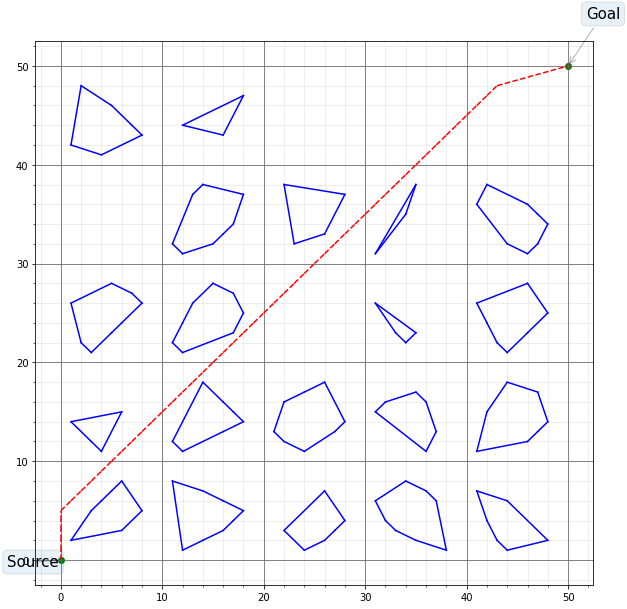

In [30]:
if solution:
    path = get_path(end_state, [])
    for i in range(len(path)-1):
        plt.plot([path[i][0], path[i+1][0]], [path[i][1], path[i+1][1]], 'r--')
    print('Path: ' + str(path))
    print('Cost: ' + str(end_state.distance_from_start))
else:
    print('No solution!')
plot_polygons(obstacles, start_point, end_point)